In [22]:
# Import libraries
from datetime import datetime
from functools import reduce
from itertools import combinations
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pickle
import xgboost as xgb
import sys
import local_functions as lf
from lightgbm import LGBMRegressor
print(sys.version)
xgb.__version__


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import datetime as dt


3.12.4 (main, Jun  7 2024, 06:33:07) [GCC 14.1.1 20240522]


In [3]:
## LIST OF CHEMICAL CLEANINGS DATES ON DF PERIOD

Chemical_days = [
    '15-06-2022',
    '16-06-2022',
    '25-10-2022',
    '27-10-2022',
    '02-01-2023',
    '08-03-2023',
    '15-04-2023',
    '17-04-2023',
    '14-06-2023',
    '21-08-2023',
    '16-10-2023',
    '08-01-2024',
    '18-03-2024']
Chemical_days = [datetime.strptime(fecha, '%d-%m-%Y').date() for fecha in Chemical_days]


In [4]:
# Read data
df0 = pd.read_csv('/home/saba/Desktop/GitHub/MBR_ML_model/CSVs/R3A_Cicles_Inf.csv')
df0.columns = ['ID','Date','Qair', 'Qperm', 'TMP', 'O2','Temp', 'TSS', 'NH4', 'NO3','Flux', 'Permeab', 'Hz']
df0.sort_values(by = 'Date', inplace = True)
df0.dropna(inplace=True)
df0.drop(['ID'], axis=1, inplace = True)
df0['Date'] = pd.to_datetime(df0['Date'])
df0.reset_index(drop = True, inplace = True)
df0.head(5)

,Date,Qair,Qperm,TMP,O2,Temp,TSS,NH4,NO3,Flux,Permeab,Hz
0,2022-10-05 08:25:20,3906.94,44.0000,-0.156667,5.67800,24.4253,11.7480,0.0,5.70733,11.4583,73.3809,29.0
1,2022-10-05 08:35:44,3902.02,44.6562,-0.157500,1.03125,24.4263,11.6931,0.0,6.18687,11.6292,73.9542,29.0
2,2022-10-05 08:45:46,3903.80,44.5187,-0.157500,0.11625,24.4125,11.7094,0.0,5.73125,11.5934,73.7207,29.0
3,2022-10-05 08:55:46,3909.99,44.8750,-0.158125,0.10125,24.3500,11.6125,0.0,5.60000,11.6862,74.0234,29.0
4,2022-10-05 09:05:46,3909.84,44.6125,-0.157500,0.10125,24.3369,11.5850,0.0,5.01500,11.6178,73.8709,29.0


In [5]:
# DATA TREATMENT
# Set absolute valure for TMP (there is no backwash is flat sheet)
df0['TMP'] = abs(df0['TMP'])

# For de Fouling Rates (FR) calculatios, set time in minutes and tmp to mbar
df0['Minute'] = (df0['Date']-df0['Date'].iloc[0]).dt.total_seconds()/60
df0['TMPmbar'] = df0['TMP']*1000
df0['FR'] = lf.calcualte_slope(df0,n = 5, Name_TMP='TMPmbar',Name_Time='Minute')

# For the chemical cleanings information
df0['Days'] = df0['Date'].dt.date
df0['Chemicals'] = np.zeros(len(df0))
df0['Chemicals'] = df0['Days'].isin(Chemical_days).astype(int)
print(f'N rows with chemicals cleanings: {sum(df0['Chemicals'])}')

# Calcualte days after each chemical cleaning
reset_points = df0['Chemicals'].cumsum()
df0['After_Chemical_h'] = df0.groupby(reset_points)['Minute'].transform(lambda x: (x - x.min()) / 60)
print(f'NaN found: {df0.isna().values.any()}')

# Calculate total resistance
df0['Visco'] = 1.793 * 10**-3 * np.exp(-0.043 * df0['Temp']**0.864)
df0['Resistance'] = (df0['TMP']*3600*1000*1000)/(df0['Flux']*df0['Visco'])
df0.columns

N rows with chemicals cleanings: 559
NaN found: False


Index(['Date', 'Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3',
       'Flux', 'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Days', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance'],
      dtype='object')

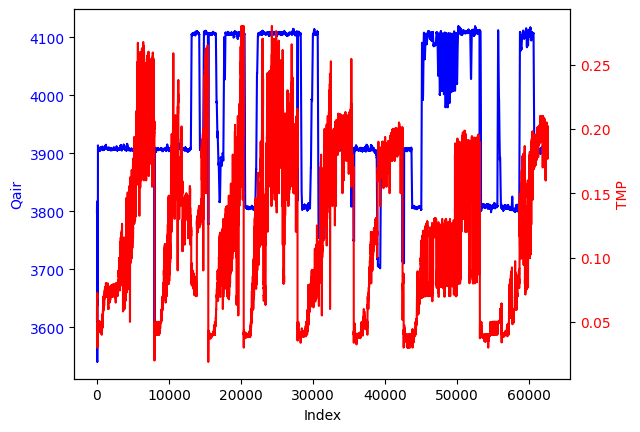

,Date,Qair,Qperm,TMP,O2,Temp,TSS,NH4,NO3,Flux,Permeab,Hz,Minute,TMPmbar,FR,Days,Chemicals,After_Chemical_h,Visco,Resistance
0,2022-10-25 17:32:42,3798.332051,34.4917,0.051667,0.110000,24.2433,13.3725,4.47417,2.00000,8.98220,178.584,25.0,29347.366667,51.6667,-0.217365,2022-10-25,1,0.0,0.000912,2.269887e+10
1,2022-10-25 17:46:29,3799.608451,35.3647,0.067647,0.110000,24.2412,13.0488,4.58176,1.99882,9.20956,134.943,25.0,29361.150000,67.6471,-0.204994,2022-10-25,1,0.0,0.000912,2.898442e+10
2,2022-10-25 18:00:01,3800.222151,45.8455,0.070000,0.110000,24.2636,12.9827,4.69727,1.95818,11.93890,170.556,26.0,29374.683333,70.0000,-0.196996,2022-10-25,1,0.0,0.000912,2.314847e+10
3,2022-10-25 20:21:01,3801.478051,27.0882,0.063922,0.571176,24.5094,12.5061,2.14490,7.87843,7.05423,109.937,25.0,29515.683333,63.9216,-0.177787,2022-10-25,1,0.0,0.000906,3.598779e+10
4,2022-10-25 20:53:59,3802.565751,25.1500,0.060000,0.110000,24.4875,12.3125,2.12063,6.39875,6.54948,109.725,25.0,29548.650000,60.0000,0.047267,2022-10-25,1,0.0,0.000907,3.636410e+10


In [6]:
# Set a copy of the DF0 to work with
df = df0.copy()
# Do a rolling mean for the air scour flow to reduce the noise
df['Qair'] = lf.rolling_mean_centered(df['Qair'].values, 100)
# Exclude the iniial and end values fue to are not representative
df = df.iloc[2370:65041]
df.reset_index(drop = True, inplace = True)

fig, ax1 = plt.subplots()
ax1.plot(df.index, df['Qair'], color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Qair', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df.index, df['TMP'], color='red')
ax2.set_ylabel('TMP', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.show()
df.head()

In [7]:
# Resamplt the df to get one value each hour
dfi = df.copy()
dfi.drop(['Days'], axis = 1, inplace = True)
dfi.set_index('Date', inplace = True)
dfi = dfi.resample('60min').median()
print(dfi.index)

DatetimeIndex(['2022-10-25 17:00:00', '2022-10-25 18:00:00',
               '2022-10-25 19:00:00', '2022-10-25 20:00:00',
               '2022-10-25 21:00:00', '2022-10-25 22:00:00',
               '2022-10-25 23:00:00', '2022-10-26 00:00:00',
               '2022-10-26 01:00:00', '2022-10-26 02:00:00',
               ...
               '2024-03-16 12:00:00', '2024-03-16 13:00:00',
               '2024-03-16 14:00:00', '2024-03-16 15:00:00',
               '2024-03-16 16:00:00', '2024-03-16 17:00:00',
               '2024-03-16 18:00:00', '2024-03-16 19:00:00',
               '2024-03-16 20:00:00', '2024-03-16 21:00:00'],
              dtype='datetime64[ns]', name='Date', length=12197, freq='60min')


Index(['Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3', 'Flux',
       'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance', 'TargetTMP'],
      dtype='object')


,Qair,Qperm,TMP,O2,Temp,TSS,NH4,NO3,Flux,Permeab,Hz,Minute,TMPmbar,FR,Chemicals,After_Chemical_h,Visco,Resistance,TargetTMP
Date,,,,,,,,,,,,,,,,,,,
2022-10-25 17:00:00,3798.970251,34.92820,0.059657,0.110000,24.24225,13.21065,4.527965,1.99941,9.095880,156.76350,25.0,29354.258333,59.6569,-0.211180,1.0,0.0,0.000912,2.584164e+10,0.05
2022-10-25 18:00:00,3800.222151,45.84550,0.070000,0.110000,24.26360,12.98270,4.697270,1.95818,11.938900,170.55600,26.0,29374.683333,70.0000,-0.196996,1.0,0.0,0.000912,2.314847e+10,0.05
2022-10-25 20:00:00,3802.021901,26.11910,0.061961,0.340588,24.49845,12.40930,2.132765,7.13859,6.801855,109.83100,25.0,29532.166667,61.9608,-0.065260,1.0,0.0,0.000907,3.617594e+10,0.05
2022-10-25 21:00:00,3806.424601,26.40310,0.067500,0.110000,24.44190,12.17405,3.613435,4.93813,6.875815,101.79500,25.0,29583.691667,67.5000,0.037297,1.0,0.0,0.000908,3.910801e+10,0.05
2022-10-25 22:00:00,3813.044701,26.14375,0.068438,0.110000,24.44125,12.07215,3.456870,4.36344,6.808265,99.05135,25.0,29643.750000,68.4375,0.016047,1.0,0.0,0.000908,4.013260e+10,0.05


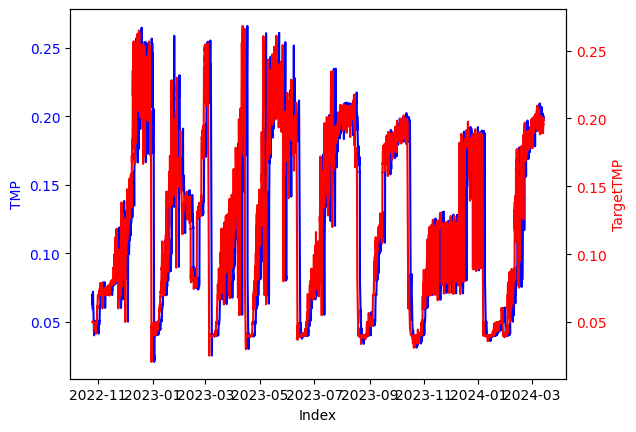

In [8]:
# Se the days to forecast
# It will create a TMP colum pinting to the "future" ccroding the actual TMP as well
target_days = 3 
dfi['TargetTMP'] = dfi['TMP'].shift(-target_days*24)
dfi.dropna(inplace = True)

# Plot TMP and target TMP
fig, ax1 = plt.subplots()
ax1.plot(dfi.index, dfi['TMP'], color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('TMP', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(dfi.index, dfi['TargetTMP'], color='red')
ax2.set_ylabel('TargetTMP', color='red')
ax2.tick_params(axis='y', labelcolor='red')

print(dfi.columns)
dfi.head()

In [10]:
dfi.index

DatetimeIndex(['2022-10-25 17:00:00', '2022-10-25 18:00:00',
               '2022-10-25 20:00:00', '2022-10-25 21:00:00',
               '2022-10-25 22:00:00', '2022-10-25 23:00:00',
               '2022-10-26 00:00:00', '2022-10-26 01:00:00',
               '2022-10-26 02:00:00', '2022-10-26 03:00:00',
               ...
               '2024-03-13 12:00:00', '2024-03-13 13:00:00',
               '2024-03-13 14:00:00', '2024-03-13 15:00:00',
               '2024-03-13 16:00:00', '2024-03-13 17:00:00',
               '2024-03-13 18:00:00', '2024-03-13 19:00:00',
               '2024-03-13 20:00:00', '2024-03-13 21:00:00'],
              dtype='datetime64[ns]', name='Date', length=9090, freq=None)

In [12]:
target_var = 'TargetTMP'
features = ['Qair', 'NH4', 'TSS', 'Visco', 'Qperm', 'After_Chemical_h', 'Resistance']

dataset_lstm = dfi.copy()

forecast_lead = 12
target = f'{target_var}_lead{forecast_lead}'

dataset_lstm[target] = dataset_lstm[target_var].shift(-forecast_lead)
dataset_lstm = dataset_lstm.iloc[:-forecast_lead]

start_test = '2023-09-01'
stop_test = '2023-12-31'
dataset_lstm_train = dataset_lstm[:start_test]
dataset_lstm_test = dataset_lstm[start_test:stop_test]

print('Test data fraction:', len(dataset_lstm_test)/len(dataset_lstm))

Test data fraction: 0.24840273187926856


In [13]:
target_mean = dataset_lstm_train[target].mean()
target_std  = dataset_lstm_train[target].std()

for col in dataset_lstm_train.columns:
    mean = dataset_lstm_train[col].mean()
    std = dataset_lstm_train[col].std()
    dataset_lstm_train[col] = (dataset_lstm_train[col] - mean) /std
    dataset_lstm_test[col] = (dataset_lstm_test[col] - mean) /std

/tmp/ipykernel_904203/1788795212.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_lstm_train[col] = (dataset_lstm_train[col] - mean) /std
/tmp/ipykernel_904203/1788795212.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_lstm_test[col] = (dataset_lstm_test[col] - mean) /std


In [15]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cpu


In [14]:
class SeqDataset(Dataset):
    def __init__(self, df, target, features, seq_length=5):
        self.features = features
        self.target = target
        self.seq_length = seq_length
        self.y = torch.tensor(df[target].values).float()
        self.X = torch.tensor(df[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.seq_length - 1:
            i_start = i - self.seq_length + 1
            x = self.X[i_start:(i+1), :]
        else:
            padding = self.X[0].repeat(self.seq_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

class LSTM(nn.Module):
    def __init__(self, num_var, hidden_units, dropout=0, num_layers=1):
        super().__init__()
        self.num_var = num_var
        self.hidden_units = hidden_units
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=num_var, \
            hidden_size=hidden_units, \
            batch_first=True, \
            dropout = dropout, \
            num_layers =self.num_layers)

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, device=x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, device=x.device).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0,c0))
        out = self.linear(hn[0]).flatten()

        return out


In [16]:
torch.manual_seed(101)
batch_size = 12
seq_length = 12

training_dataset = SeqDataset(dataset_lstm_train, target=target, \
    features=features, seq_length=seq_length)

test_dataset = SeqDataset(dataset_lstm_test, target=target, \
    features=features, seq_length=seq_length)


training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(training_loader))
print(X.shape)
print(y.shape)

torch.Size([12, 12, 7])
torch.Size([12])


In [17]:
learning_rate = 5e-3
num_hidden_units = 16

model = LSTM(num_var=len(features), hidden_units=num_hidden_units, dropout=0.8, num_layers=3).to(device)
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
def training_model(data_loader, model, loss_fun, optimizer, device):
    num_batch = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss = loss_fun(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / num_batch
    print(f'Training loss: {average_loss}')

def test_model(data_loader, model, loss_fun, device):
    num_batch = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            total_loss += loss_fun(output, y).item()

    average_loss = total_loss / num_batch
    print(f'Test loss: {average_loss}')
    return average_loss

def predict(data_loader, model, device):
    output = torch.tensor([])
    output = output.to(device)
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            X = X.to(device)
            _ = _.to(device)
            y_hat = model(X)
            output = torch.cat((output, y_hat))

    return output

In [19]:
print('Untrained test\n---------')
test_model(test_loader, model, loss_fun, device=device)
print()


for ix_epoch in range(20):
    print(f'Epoch {ix_epoch}\n----------')
    training_model(training_loader, model, loss_fun, optimizer=optimizer, device=device)
    val_loss = test_model(test_loader, model, loss_fun, device=device)
    #scheduler.step(val_loss)
    print()

Untrained test
---------
Test loss: 0.7563867603646631

Epoch 0
----------
Training loss: 0.35940886242416187
Test loss: 1.02424032993889

Epoch 1
----------
Training loss: 0.22052199019163587
Test loss: 1.131591874385312

Epoch 2
----------
Training loss: 0.1893377369390942
Test loss: 0.954495775737822

Epoch 3
----------
Training loss: 0.1553865306426866
Test loss: 1.0644616531945041

Epoch 4
----------
Training loss: 0.14928711888253074
Test loss: 1.5113563506202674

Epoch 5
----------
Training loss: 0.12379402369755743
Test loss: 1.4092504313013434

Epoch 6
----------
Training loss: 0.12351479758700425
Test loss: 1.3779457127656838

Epoch 7
----------
Training loss: 0.10636984430548459
Test loss: 1.5521774857098787

Epoch 8
----------
Training loss: 0.12047329397948858
Test loss: 1.2417402224270924

Epoch 9
----------
Training loss: 0.12375336191303818
Test loss: 1.4462755635396845

Epoch 10
----------
Training loss: 0.10461001241187728
Test loss: 1.469576543783447

Epoch 11
------

In [20]:
train_eval_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=False)



dataset_lstm_train['Model forecast'] = predict(train_eval_loader, model, device=device).cpu().numpy()
dataset_lstm_test['Model forecast'] = predict(test_loader, model, device=device).cpu().numpy()


dataset_output = pd.concat((dataset_lstm_train, dataset_lstm_test))[[target,'Model forecast']]

for col in dataset_output.columns:
    dataset_output[col] = dataset_output[col] * target_std + target_mean


#print(dataset_output)

/tmp/ipykernel_904203/1523299956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_lstm_train['Model forecast'] = predict(train_eval_loader, model, device=device).cpu().numpy()
/tmp/ipykernel_904203/1523299956.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_lstm_test['Model forecast'] = predict(test_loader, model, device=device).cpu().numpy()


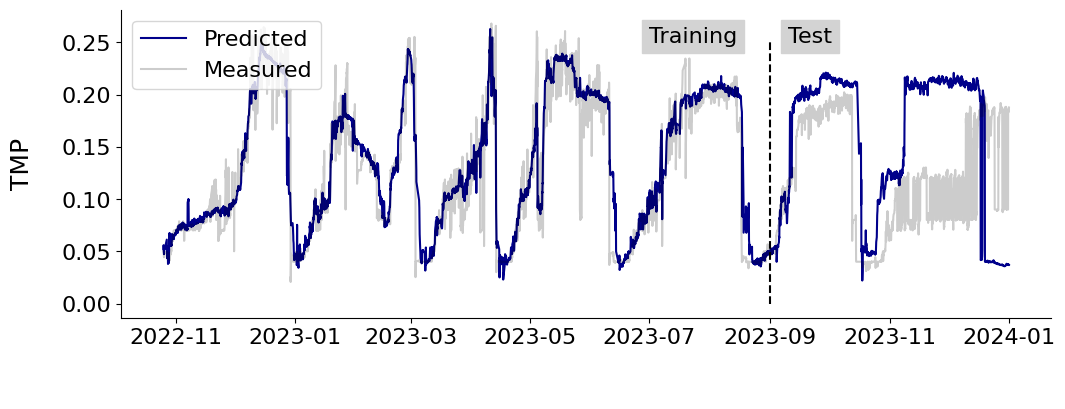

In [25]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(dataset_output['Model forecast'], color='darkblue', label='Predicted')
ax.plot(dataset_output[target], 'k', alpha=0.2, label='Measured')
ax.vlines(x=dt.datetime(2023,9,1), ymin=0, ymax=0.25, color='black', linestyles='dashed')
ax.annotate('Training', xy=(dt.datetime(2023,7, 1),0.25), xytext=(dt.datetime(2023,7,1),0.25), size=16, color='black', bbox=dict(boxstyle='square', pad=0.3, fc='lightgray', ec='lightgray' ))
ax.annotate('Test', xy=(dt.datetime(2023,9,10),0.25), xytext=(dt.datetime(2023,9,10),0.25), size=16, color='black', bbox=dict(boxstyle='square', pad=0.3, fc='lightgray', ec='lightgray' ))
ax.set_xlabel(' ', fontsize=18, labelpad=20)
ax.set_ylabel('TMP', fontsize=18, labelpad=20)
ax.tick_params(labelsize=16)
ax.legend(loc='upper left', fontsize=16)

sns.despine()